# This notebook builds a general stock market RNN then finetunes it for a particular basket of stocks

In [1]:
import tensorflow as tf
import os
from datetime import datetime


/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import signal
import pickle

In [3]:
import pandas as pd

## I run Tensorflow in Nvidia-Docker, which doesn't come with pandas_datareader installed 

In [4]:
!pip install pandas_datareader

In [5]:
from pandas_datareader import data as web

In [21]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (22, 9)
start = datetime(2018,9,1)
stop = datetime(2020,7,30)

In [7]:
# 'MSFT', 'GPRO', 'SBUX', 'BABA','FIT','GE','LUV''BAC','RTX','TWTR','DIS','AAPL', 'NFLX',

os.environ['ALPHAVANTAGE_API_KEY'] = "XFF5HEBRJ25DX4NR"

In [8]:
tsla = web.DataReader("TSLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [9]:
# TODO: Should duplicate items in the basket in different orders to expand the training set

In [10]:
googl = web.DataReader("GOOGL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [11]:
fb = web.DataReader("FB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [12]:
twtr = web.DataReader("TWTR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [13]:
rtx = web.DataReader("RTX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [14]:
aapl = web.DataReader("AAPL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [15]:
invvy = web.DataReader("INVVY", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
bac = web.DataReader("BAC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
huya = web.DataReader("HUYA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [16]:

uber= web.DataReader("UBER", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
snap = web.DataReader("SNAP", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [18]:
sedg = web.DataReader("SEDG", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
acb = web.DataReader("ACB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
baba = web.DataReader("BABA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [19]:
dal = web.DataReader("DAL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
nkla = web.DataReader("NKLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [20]:
amd = web.DataReader("AMD", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
sogo = web.DataReader("SOGO", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
intc = web.DataReader("INTC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [22]:
ge = web.DataReader("GE", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
maxr = web.DataReader("MAXR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
cgc = web.DataReader("CGC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [26]:
chwy = web.DataReader("CHWY", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
kodk = web.DataReader("KODK", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
nflx = web.DataReader("NFLX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [24]:
dis = web.DataReader("DIS", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
gpro = web.DataReader("GPRO", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
sbux = web.DataReader("SBUX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [27]:
aapl = aapl.copy()
aapl = aapl.reset_index()

tsla = tsla.copy()
tsla=tsla.reset_index()

fb = fb.copy()
fb=fb.reset_index()



twtr = twtr.copy()
twtr = twtr.reset_index()

googl = googl.copy()
googl=googl.reset_index()

invvy = invvy.copy()
invvy=invvy.reset_index()

bac = bac.copy()
bac=bac.reset_index()

huya = huya.copy()
huya=huya.reset_index()

uber = uber.copy()
uber=uber.reset_index()

snap = snap.copy()
snap=snap.reset_index()



acb = acb.copy()
acb=acb.reset_index()

baba = baba.copy()
baba=baba.reset_index()


dal = dal.copy()
dal=dal.reset_index()

nkla = nkla.copy()
nkla=nkla.reset_index()

amd = amd.copy()
amd=amd.reset_index()

sogo = sogo.copy()
sogo=sogo.reset_index()

intc = intc.copy()
intc=intc.reset_index()


ge = ge.copy()
ge=ge.reset_index()

maxr = maxr.copy()
maxr= maxr.reset_index()

cgc = cgc.copy()
cgc=cgc.reset_index()

chwy = chwy.copy()
chwy= chwy.reset_index()

kodk = kodk.copy()
kodk=kodk.reset_index()

nflx = nflx.copy()
nflx=nflx.reset_index()



dis = dis.copy()
dis=dis.reset_index()

gpro = gpro.copy()
gpro= gpro.reset_index()

sbux = sbux.copy()
sbux=sbux.reset_index()



In [28]:

basket = ['TSLA','GOOGL', 'FB','RTX','TWTR','AAPL', 'INVVY','BAC','HUYA','UBER','SNAP', 'DAL', 'NKLA', 'AMD', 'SOGO', 
         'INTC' , 'CGC', 'MAXR', 'GE', 'CHWY', 'KODK','NFLX', 'DIS', 'GPRO', 'SBUX']


aapl['symbol'] = "AAPL"
googl['symbol'] ='GOOGL'
fb['symbol'] = 'FB'
twtr['symbol'] ='TWTR'
rtx['symbol'] ='RTX'
tsla['symbol'] = 'TSLA'
invvy['symbol'] = 'INVVY'
bac['symbol'] = 'BAC'
huya['symbol'] = 'HUYA'
uber['symbol'] = 'UBER'
snap['symbol'] = 'SNAP'
dal['symbol'] = 'DAL'
nkla['symbol'] = 'NKLA'
amd['symbol'] = 'AMD'
sogo['symbol'] = 'SOGO'
intc['symbol'] = 'INTC'

cgc['symbol'] = "CGC"
maxr['symbol'] ='MAXR'
ge['symbol'] = 'GE'
chwy['symbol'] ='CHWY'
kodk['symbol'] ='KODK'
nflx['symbol'] = 'NFLX'
dis['symbol'] = 'DIS'
gpro['symbol'] = 'GPRO'
sbux['symbol'] = 'SBUX'
#baba['symbol'] = 'BABA'
##fit['symbol'] = 'FIT'
#luv['symbol'] = 'LUV'
#sgh['symbol'] = 'SGH'
#sedg['symbol'] = 'SEDG'
#cae['symbol'] = 'CAE'
#can['symbol'] = 'CAN'

#crm['symbol'] = "CRM"
#shop['symbol'] ='SHOP'
#gnus['symbol'] ='GNUS'
#tlk['symbol'] = 'TLK'
#sfix['symbol'] = 'SFIX'
#oas['symbol'] = 'OAS'
#htz['symbol'] = 'HTZ'
#wins['symbol'] = 'WINS'
#duo['symbol'] = 'DUO'
#ttm['symbol'] = 'TTM'
#lens['symbol'] = 'LEN'
###nh['symbol'] = 'NH'#
#arct['symbol'] = 'ARCT'#
#domo['symbol'] = 'DOMO'

#uone['symbol'] = "UONE"
#kmx['symbol'] ='KMX'
#jbl['symbol'] = 'JBL'
#mgnx['symbol'] ='MGNX'
#idex['symbol'] ='IDEX'
#jfu['symbol'] = 'JFU'
#frg['symbol'] = 'FRG'


df = pd.concat([googl,fb,twtr,rtx,aapl,tsla, invvy, bac, huya, uber, snap, dal, nkla, amd, sogo, intc,cgc,maxr, ge,chwy,kodk,nflx,dis, gpro, sbux], ignore_index = True)
sum(df['symbol']=='GOOGL')

4014

# Feature engineering

De-trend and add a few extra features

In [29]:
X_scalers = {}
y_scalers = {}
for stock in basket:
    for col in ('close', 'high', 'low', 'open', 'volume'):
        df[col] = df[col].astype(float)
        df.loc[df['symbol'] == stock, col] = signal.detrend(df[df['symbol'] == stock][col])
    df.loc[df['symbol'] == stock, 'mean_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).mean()
    df.loc[df['symbol'] == stock, 'mean_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).mean()
    df.loc[df['symbol'] == stock, 'std_close_price_2'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=2).std()
    df.loc[df['symbol'] == stock, 'std_close_price_3'] = df.loc[df['symbol'] == stock, 'close'].rolling(window=3).std()

In [30]:
df

,index,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3
0,2004-08-19,-121.060464,-120.001831,-121.578986,-120.198711,2.830995e+07,GOOGL,NaN,NaN,NaN,NaN
1,2004-08-20,-120.292825,-115.215954,-117.269624,-112.456296,6.489935e+06,GOOGL,-116.327504,NaN,5.474714,NaN
2,2004-08-23,-110.775186,-111.050077,-108.950261,-111.598881,1.916425e+06,GOOGL,-112.027589,-114.751296,0.606284,4.737039
3,2004-08-24,-110.527546,-113.164201,-114.660899,-116.361466,-1.087686e+06,GOOGL,-113.980174,-113.472214,3.367656,2.538626
4,2004-08-25,-117.239907,-116.998324,-114.581537,-115.464051,-7.141697e+06,GOOGL,-115.912759,-114.474799,0.634568,2.530715
...,...,...,...,...,...,...,...,...,...,...,...
68613,2020-07-23,6.074087,5.687785,4.692955,4.541991,-2.464389e+06,SBUX,5.487127,5.205597,1.336625,1.063513
68614,2020-07-24,4.463815,4.602475,4.892726,4.951718,-4.587189e+06,SBUX,4.746854,5.308657,0.289721,0.994403
68615,2020-07-27,5.059543,5.302165,5.312497,5.621445,-3.490506e+06,SBUX,5.286582,5.038385,0.473569,0.544921
68616,2020-07-28,5.463271,4.976855,4.322667,3.791173,2.010679e+06,SBUX,4.706309,4.788112,1.294198,0.926040


In [31]:
X_scalers = {stock:{} for stock in basket}
y_scalers = {}

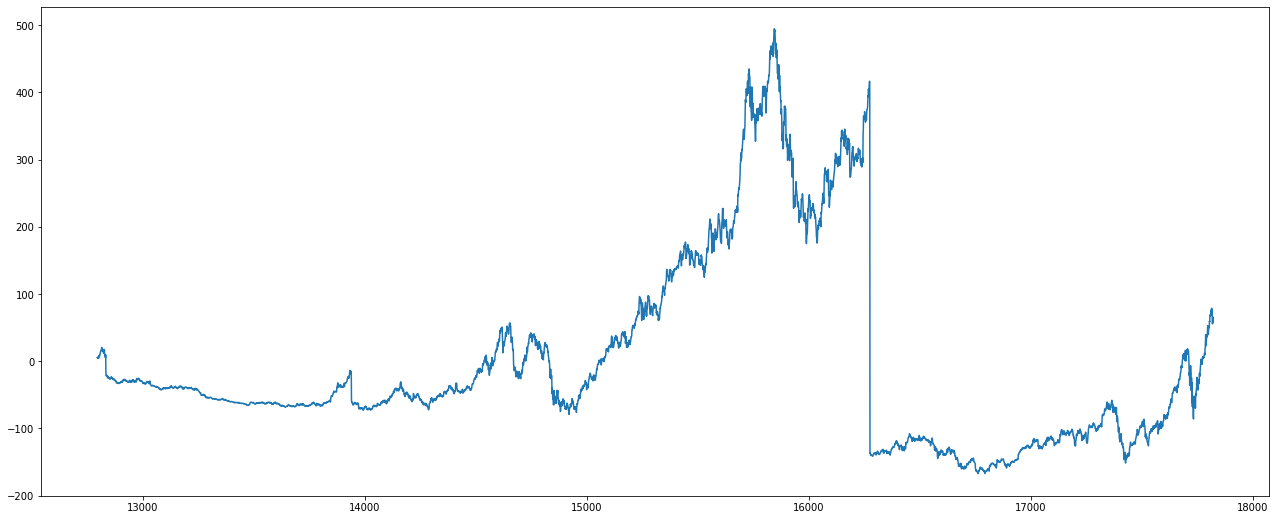

In [32]:
plt.plot(df[df['symbol'] == 'AAPL']['close'])
plt.show()

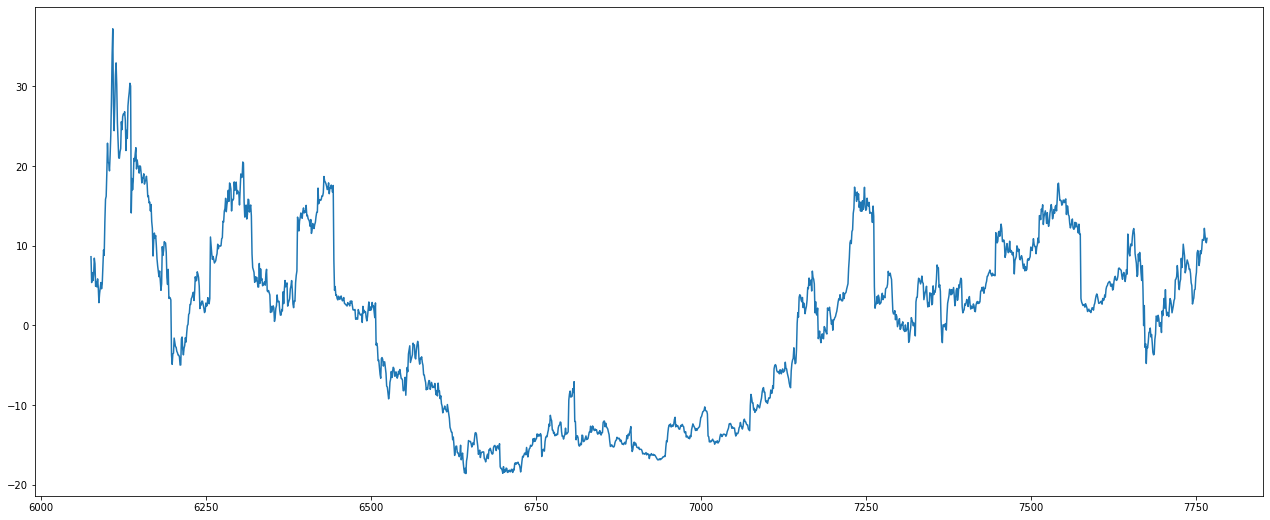

In [33]:
plt.plot(df[df['symbol'] == 'TWTR']['close'])
plt.show()

In [34]:
df['tomo_gain'] = df['close'].shift(-1) - df['close']
df['yday_gain'] = df['tomo_gain'].shift(1)

# This is not ok - note the last one

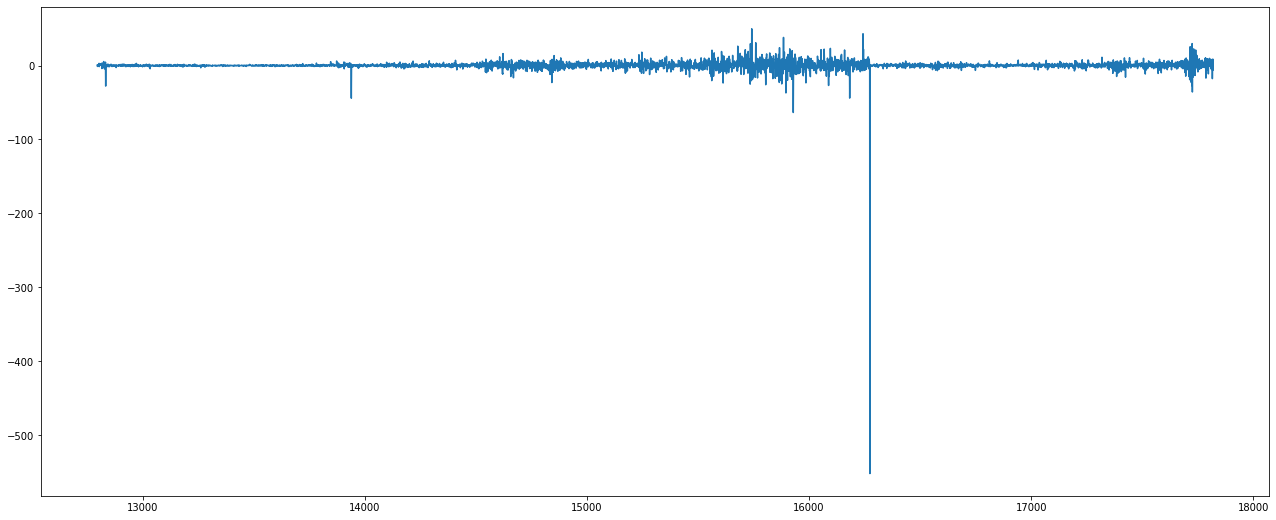

In [35]:
plt.plot(df[df['symbol'] == 'AAPL'][:-1]['tomo_gain'])
plt.show()

# This is better

In the for loop below, the last row of each stock symbol is dropped.

In [36]:
plt.show()
df[df['symbol']=='TWTR']

,index,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain
6076,2013-11-07,8.728905,12.976895,8.422278,8.602820,9.404936e+07,TWTR,NaN,NaN,NaN,NaN,-3.244059,-6.305214
6077,2013-11-08,9.564909,9.833073,5.113059,5.358761,4.275051e+06,TWTR,6.980791,NaN,2.293896,NaN,1.255941,-3.244059
6078,2013-11-11,4.140912,5.899251,3.833841,6.614702,-7.534363e+06,TWTR,5.986732,6.858761,0.888084,1.635742,-0.994059,1.255941
6079,2013-11-12,7.306915,6.685430,6.269622,5.620643,-1.732958e+07,TWTR,6.117673,5.864702,0.702906,0.662586,0.705941,-0.994059
6080,2013-11-13,4.682919,5.781608,5.205404,6.326584,-1.495599e+07,TWTR,5.973614,6.187310,0.499176,0.511455,2.095941,0.705941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,2020-07-23,11.406431,13.564939,11.675584,12.165413,6.996580e+07,TWTR,11.412443,11.182806,1.064861,0.851566,-0.894059,1.505941
7764,2020-07-24,12.042435,11.856118,11.321366,11.271354,2.769439e+06,TWTR,11.718384,11.365413,0.632195,0.757364,-0.684059,-0.894059
7765,2020-07-27,11.348338,10.912296,10.277147,10.587295,2.614415e+06,TWTR,10.929325,11.341354,0.483703,0.791384,-0.234059,-0.684059
7766,2020-07-28,10.224441,10.648475,10.602929,10.353237,-6.728083e+06,TWTR,10.470266,10.737295,0.165505,0.477085,0.555941,-0.234059


# Create datetime features

In [37]:
def completed_quarter(dt):
    prev_quarter_map = ((4, -1), (1, 0), (2, 0), (3, 0))
    quarter, yd = prev_quarter_map[(dt.month - 1) // 3]
    return  quarter

In [38]:

for stock in basket:
    days =[]
    weeks = []
    quarter = []
    as_date = []   
    for x in df.loc[df['symbol'] == stock,'index']:
        datetime.strptime(x, '%Y-%m-%d')
    for date in as_date:
        days.append(date.day)
        weeks.append(date.isocalendar()[1])
        quarter.append(completed_quarter(date))
    df.loc[df['symbol'] == stock,'dayofweek'] = days
    df.loc[df['symbol'] == stock,'quarter'] = quarter
    df.loc[df['symbol'] == stock,'weekofyear'] = weeks


ValueError: Must have equal len keys and value when setting with an iterable

In [39]:
df.head()
df = df.drop(['index'],axis=1)
df = df.dropna(axis=0)
df[df['symbol'] == 'GOOGL']

,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain,dayofweek


In [40]:
for stock in basket:
    df = df.drop(df.index[len(df[df['symbol'] == stock]) - 1], axis=0)
    outliers = abs(df[df['symbol'] == stock]['tomo_gain']) < df[df['symbol'] == stock]['tomo_gain'].std() * 3
    df[df['symbol'] == stock] = df[df['symbol'] == stock].loc[:, :][outliers]
    df = df.drop(df[df['symbol'] == stock].iloc[-1].name) # get rid of last because next is a different stock
    pre_y = df[df['symbol'] == stock]['tomo_gain'].values
    y_scalers[stock] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
    for col in ('close', 'high', 'low', 'open', 'volume', 'mean_close_price_2', \
               'mean_close_price_3', 'std_close_price_2', 'std_close_price_3', 'yday_gain'):
        pre_x = df[df['symbol'] == stock][col]
        X_scalers[stock][col] = make_pipeline(StandardScaler(), MinMaxScaler(feature_range=(-1, 1)))
        df.loc[df['symbol'] == stock, col] = X_scalers[stock][col].fit_transform(pre_x.values.reshape(-1,1))
    df.loc[df['symbol'] == stock, 'tomo_gain'] = y_scalers[stock].fit_transform(pre_y.reshape(-1, 1)).reshape(-1)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [41]:
df.head

<bound method NDFrame.head of Empty DataFrame
Columns: [open, high, low, close, volume, symbol, mean_close_price_2, mean_close_price_3, std_close_price_2, std_close_price_3, tomo_gain, yday_gain, dayofweek]
Index: []>

# Save the feature scalers

In [70]:
pickle.dump(X_scalers, open('x_scalers.pkl', 'wb'))
pickle.dump(y_scalers, open('y_scalers.pkl', 'wb'))

# Note same shape but now different scale

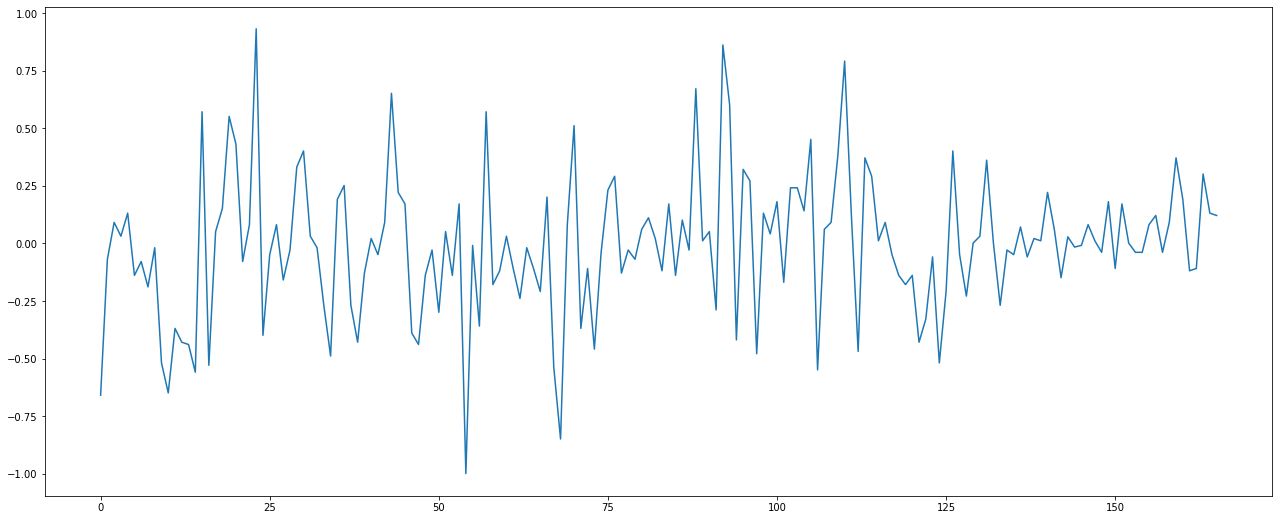

In [71]:
plt.plot(pre_y)
plt.show()

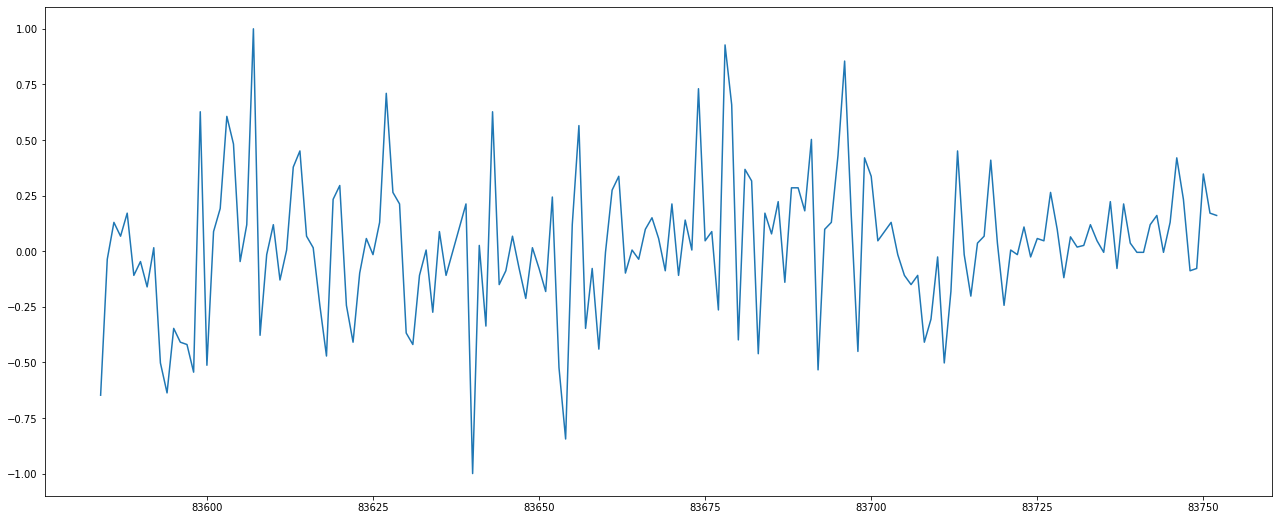

In [72]:

plt.plot( df.loc[df['symbol'] == basket[-1], 'tomo_gain'])

In [73]:
df = df.dropna(axis=0)

In [74]:
df.head()


,open,high,low,close,volume,symbol,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,tomo_gain,yday_gain
2,-0.436131,-0.422222,-0.430685,-0.430526,-0.645228,GOOGL,-0.435217,-0.443569,-0.996985,-0.972165,-0.120909,0.645808
3,-0.435494,-0.427640,-0.445379,-0.442824,-0.720611,GOOGL,-0.440271,-0.440252,-0.983132,-0.985355,0.001569,0.629429
4,-0.452765,-0.437467,-0.445174,-0.440506,-0.872526,GOOGL,-0.445274,-0.442852,-0.996843,-0.985402,0.018447,0.645925
5,-0.452874,-0.438195,-0.443761,-0.436175,-0.924949,GOOGL,-0.441941,-0.444743,-0.994076,-0.992745,-0.060968,0.648198
6,-0.445367,-0.437078,-0.441704,-0.441320,-0.946991,GOOGL,-0.442349,-0.444240,-0.992958,-0.994160,-0.112470,0.637502


In [75]:
num_df_cols = df.shape[1] - 1 + len(basket) - 1
print(num_df_cols)
df.shape

42


(82703, 12)

In [76]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(num_df_cols, input_shape=(1, num_df_cols)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(32, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1)) # dont squash output gradient

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [77]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [78]:
X = df.drop(['tomo_gain','symbol'], axis=1)
y = df['tomo_gain']

In [79]:
X

,open,high,low,close,volume,mean_close_price_2,mean_close_price_3,std_close_price_2,std_close_price_3,yday_gain
2,-0.436131,-0.422222,-0.430685,-0.430526,-0.645228,-0.435217,-0.443569,-0.996985,-0.972165,0.645808
3,-0.435494,-0.427640,-0.445379,-0.442824,-0.720611,-0.440271,-0.440252,-0.983132,-0.985355,0.629429
4,-0.452765,-0.437467,-0.445174,-0.440506,-0.872526,-0.445274,-0.442852,-0.996843,-0.985402,0.645925
5,-0.452874,-0.438195,-0.443761,-0.436175,-0.924949,-0.441941,-0.444743,-0.994076,-0.992745,0.648198
6,-0.445367,-0.437078,-0.441704,-0.441320,-0.946991,-0.442349,-0.444240,-0.992958,-0.994160,0.637502
...,...,...,...,...,...,...,...,...,...,...
83748,0.102734,0.327776,0.130857,0.070230,1.000000,0.047345,0.001516,-0.754454,-0.703252,0.403226
83749,0.183643,0.184725,0.102109,0.017712,-0.347681,0.064149,0.074026,-0.848053,-0.908854,0.153226
83750,0.113370,0.154569,0.016092,-0.030384,-0.203264,0.011348,0.068083,-0.860977,-0.890094,0.161290
83751,0.056436,0.124413,0.001661,0.102787,-0.426650,0.055994,0.080119,-0.612297,-0.848085,0.491935


In [80]:
dummies = pd.get_dummies(df['symbol'])
dummies

,AAPL,AMD,BABA,BAC,CAE,CAN,CGC,CHWY,DAL,DIS,...,NKLA,RTX,SBUX,SEDG,SGH,SNAP,SOGO,TSLA,TWTR,UBER
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83748,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83749,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83750,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83751,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
X.shape

(82703, 10)

In [82]:
X = np.append(X, dummies.values, axis=1)

In [83]:
X.shape

(82703, 42)

In [84]:
X.shape


(82703, 42)

In [85]:
# Reshape to num_samples, timesteps, num_features
X = np.reshape(X, ( -1,1, num_df_cols))

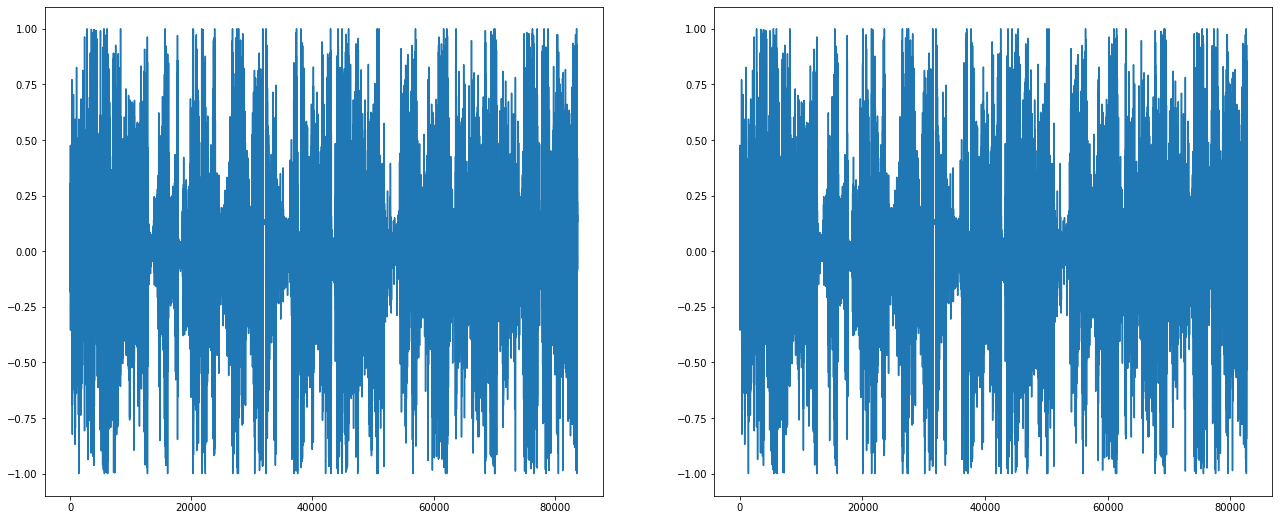

In [86]:
plt.subplot(1,2,1)
plt.plot(y)
plt.subplot(1,2,2)
plt.plot(df['tomo_gain'].values)

# Fit the base model

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Sanity checks

In [89]:
model.reset_states()

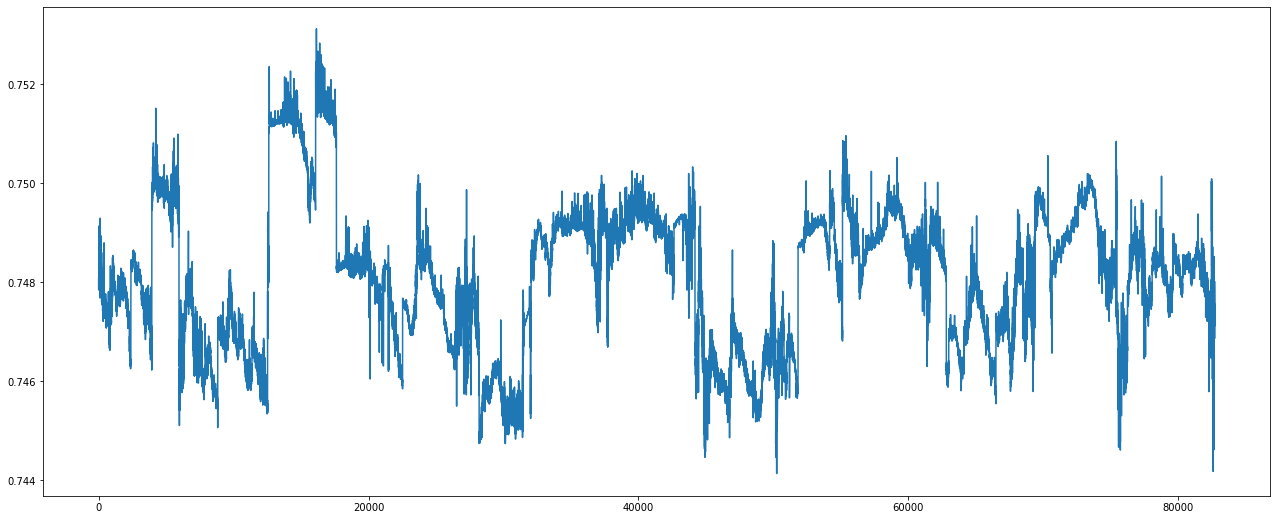

In [90]:
plt.plot(model.predict(X))

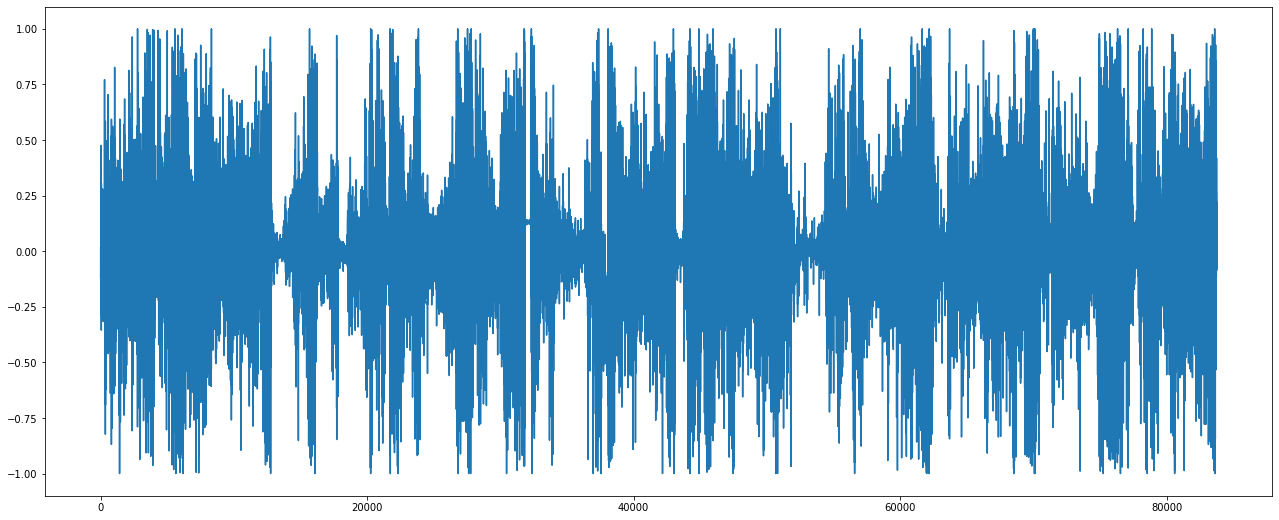

In [91]:
plt.plot(y)

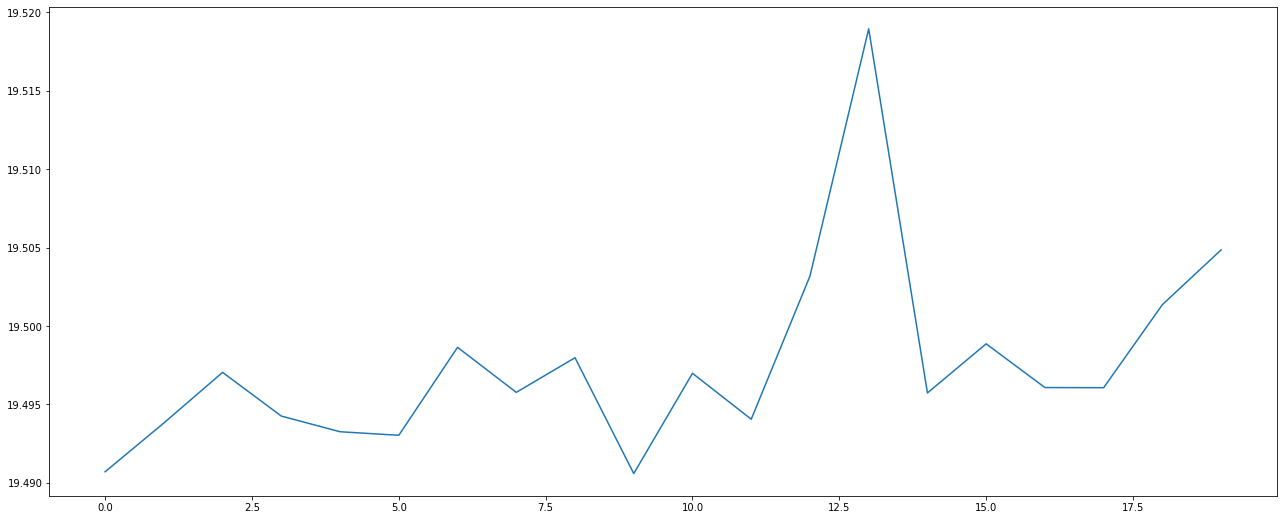

In [92]:
plt.plot(y_scalers['AAPL'].inverse_transform(model.predict(X[100:120])))

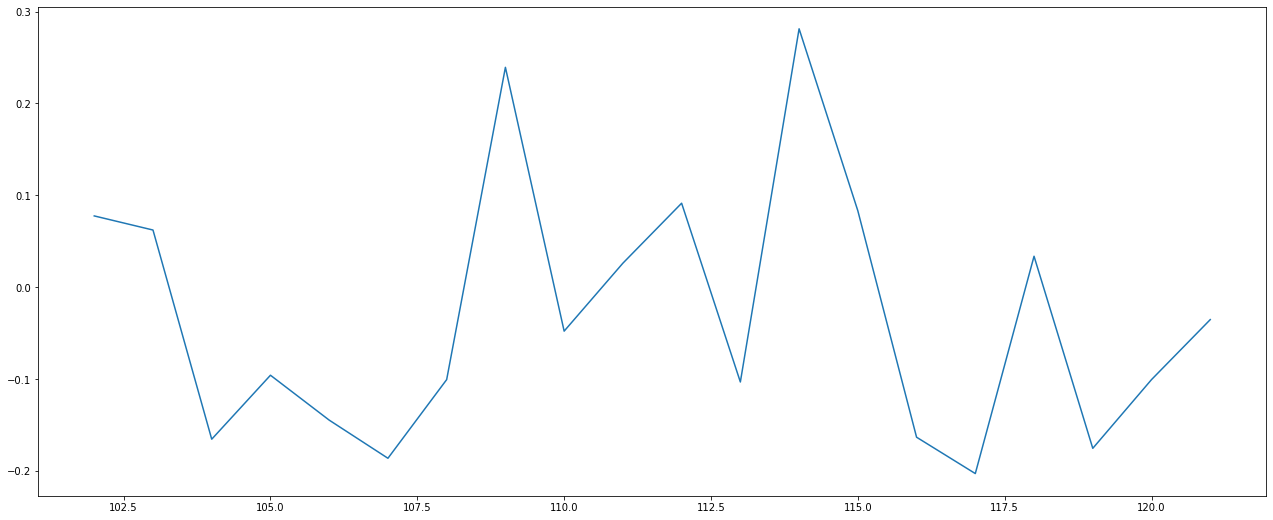

In [93]:
plt.plot(y[100:120])

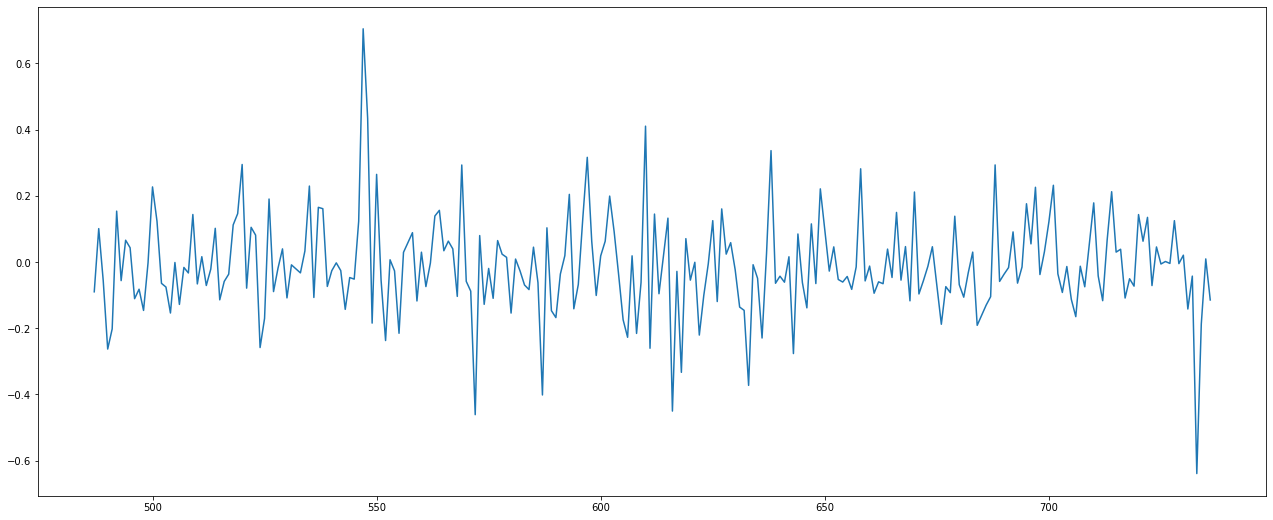

In [94]:
plt.plot(y[482:728]) # the range for TTNP

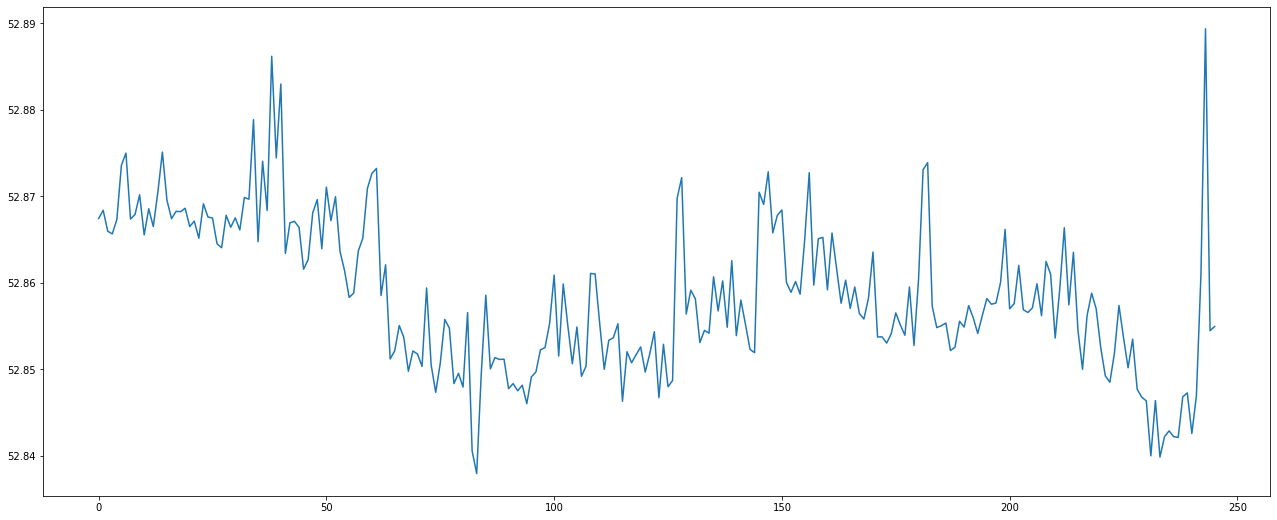

In [95]:
plt.plot(y_scalers['TSLA'].inverse_transform(model.predict(np.reshape(X[482:728], (-1, 1, num_df_cols)))))

In [96]:
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums

In [97]:
pad_stock('AAPL')

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [98]:
model.save('market_model.h5')

In [99]:
#model = tf.keras.models.load_model('market_model.h5')

## Pop off the model head and add a different one that we will finetune per stock

In [100]:
model.layers

In [101]:
model.pop()
model.pop()

In [102]:
# Freeze the 2 older dense layers
model.layers[0].trainable = False
model.layers[3].trainable = False

In [103]:
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

In [104]:
basket_dfs = {}
specific_models = {}
for stock in basket:
    basket_dfs[stock] = df[df['symbol'] == stock]
    specific_models[stock] = tf.keras.models.clone_model(model)
    specific_models[stock].set_weights(model.get_weights())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [105]:
specific_models['TSLA'].layers

In [106]:
for stock in basket:
    specific_models[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [107]:
Xes = {}
ys = {}
for stock in basket:
    repeated_dummies = pad_stock(stock).reshape(1,-1).repeat(len(basket_dfs[stock]),axis=0)
    Xes[stock] = np.append(basket_dfs[stock].drop(['tomo_gain', 'symbol'], axis=1).values, repeated_dummies, axis=1)
    Xes[stock] = np.reshape(Xes[stock], (-1, 1, num_df_cols))
    ys[stock] = basket_dfs[stock]['tomo_gain'].values.reshape(-1,1)


In [108]:
Xes_train, ys_train, Xes_test, ys_test, best_model_scores, best_model = {}, {}, {}, {}, {}, {}

In [109]:
for stock in basket:
    best_model_scores[stock] = 1e6
for stock in basket:
    Xes_train[stock] = Xes[stock][:-5]
    ys_train[stock] = ys[stock][:-5]
    Xes_test[stock] = Xes[stock][-5:]
    ys_test[stock] = ys[stock][-5:]
    for i in range(8):
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=64, epochs=100, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=16, epochs=30, verbose=0)
        specific_models[stock].fit(Xes_train[stock], ys_train[stock], batch_size=1, epochs=1, verbose=0)
        evaluation = specific_models[stock].evaluate(Xes_test[stock], ys_test[stock])[0]
        if evaluation < best_model_scores[stock]:
            best_model_scores[stock] = evaluation
            print('now saving {} because it was the best with eval score {}'.format(stock, evaluation))
            best_model[stock] = tf.keras.models.clone_model(specific_models[stock])
            best_model[stock].set_weights(specific_models[stock].get_weights())
            best_model[stock].compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
        else:
            print('did not save {} because it did not improve with eval score {}'.format(stock, evaluation))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

# Now let's reassign it for simplicity

In [122]:
for stock in basket:
    specific_models[stock] = best_model[stock]

# Sanity checks

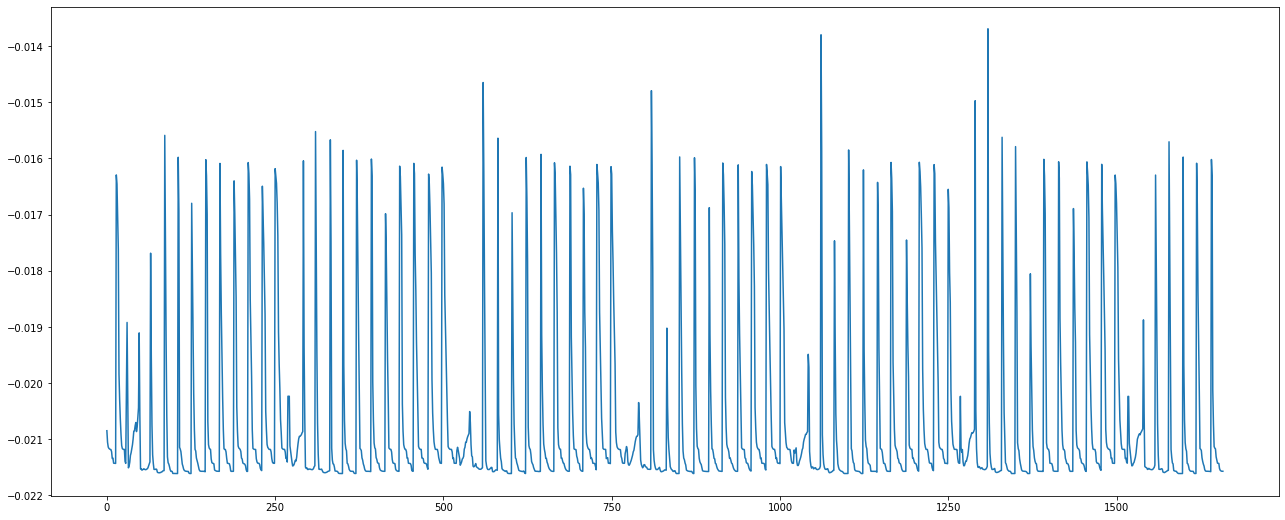

In [123]:
plt.plot(y_scalers['TWTR'].inverse_transform(specific_models['TWTR'].predict(Xes['TWTR'])))

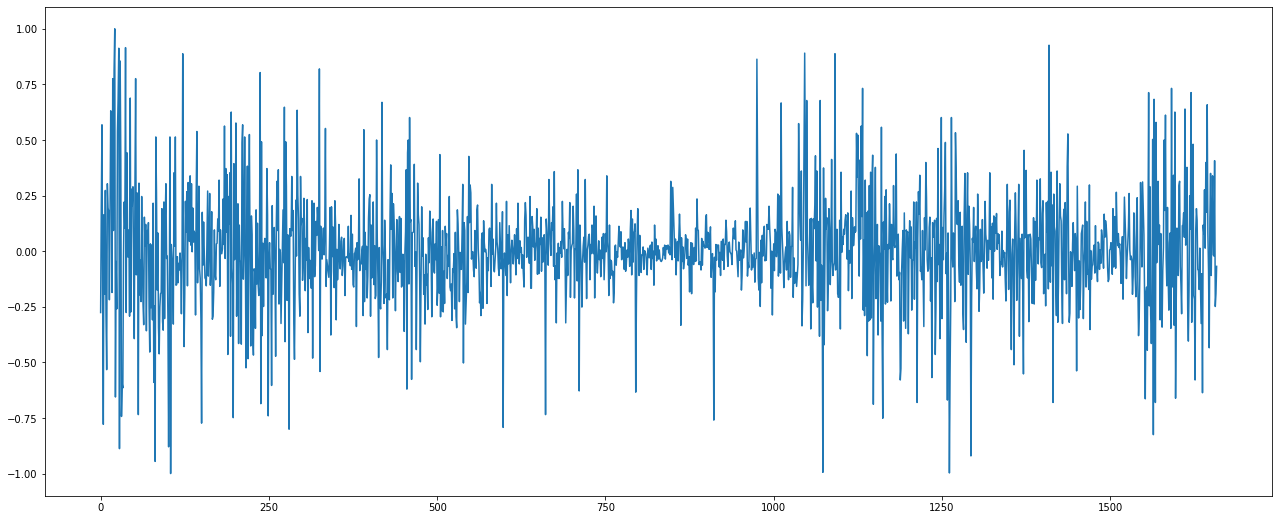

In [124]:
plt.plot(ys['TWTR'])

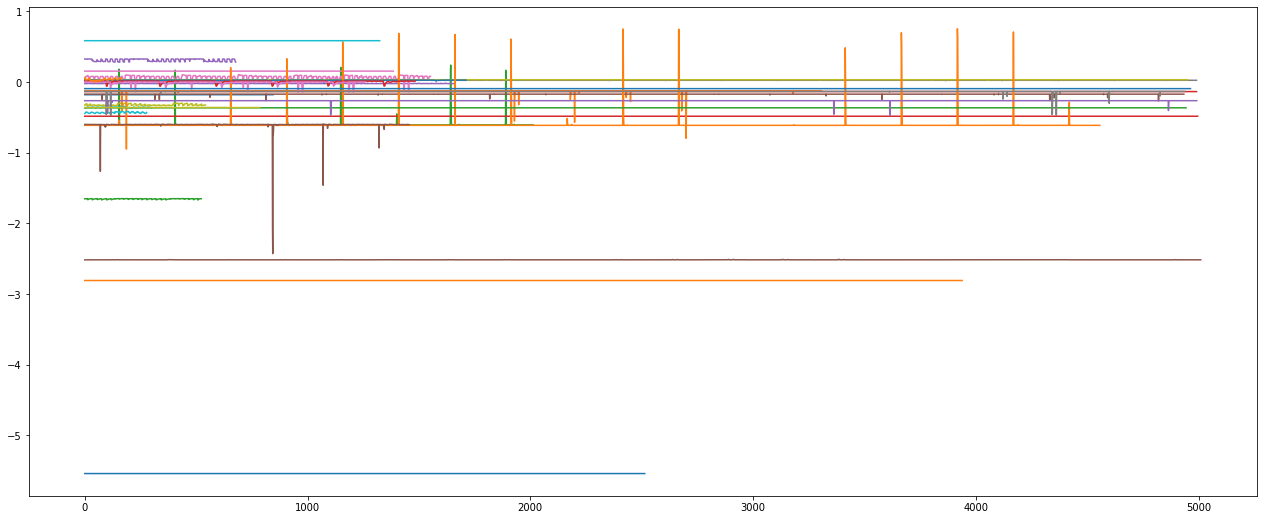

In [125]:
for stock in basket:
    plt.plot(y_scalers[stock].inverse_transform(specific_models[stock].predict(Xes[stock])))

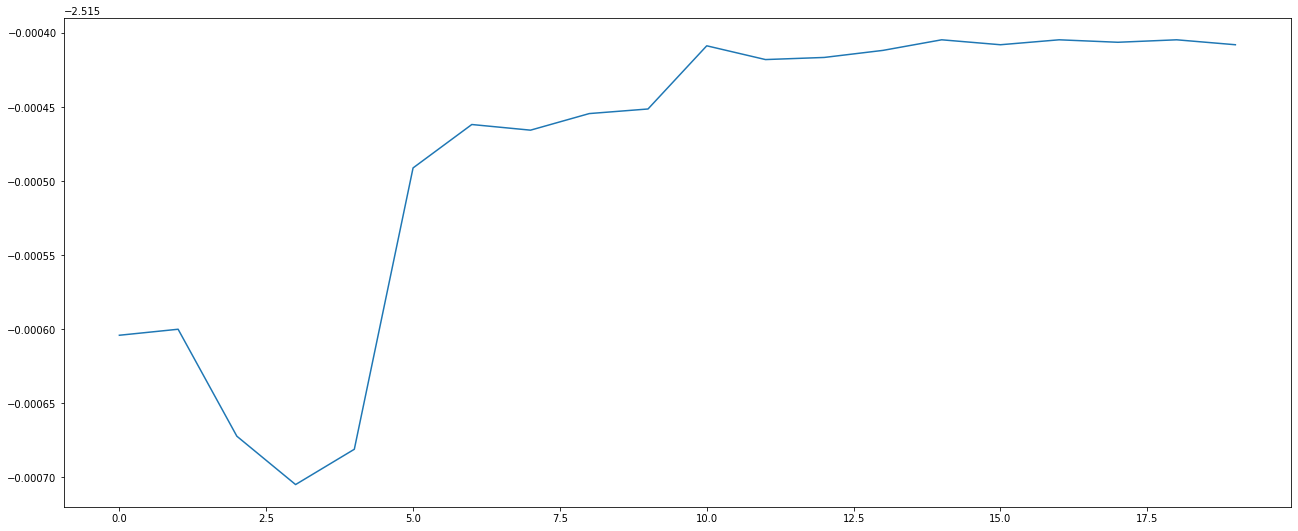

In [126]:
plt.plot(y_scalers['AAPL'].inverse_transform(specific_models['AAPL'].predict(Xes['AAPL'][100:120])))

# Make some predictions for tomorrow

I'm not sure if these have valid units by now, but definitely larger numbers mean higher gains, and v.v. Note that the RNN should be warmed up on a few previous days' data first; one-off predictions will not be as good so don't use it like this (see below instead).

In [127]:
import torch
for stock in basket:
    today = df[df['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(tf.convert_to_tensor(np.asarray(np.reshape(today, (-1, 1, num_df_cols))).astype(np.float32)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asarray(pred)))

ModuleNotFoundError: No module named 'torch'

# Save the fine tuned models

In [128]:
for stock, model in specific_models.items():
    model.save('finetuned_{}.h5'.format(stock))

# With the models built, run this to generate new predictions for the most recent day

In [129]:
X_scalers = pickle.load(open('x_scalers.pkl', 'rb'))
y_scalers = pickle.load(open('y_scalers.pkl', 'rb'))

In [133]:
specific_models = {}
for stock in basket:
    specific_models[stock] = tf.keras.models.load_model('finetuned_{}.h5'.format(stock))

In [134]:
tsla = web.DataReader("TSLA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
googl = web.DataReader("GOOGL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
fb = web.DataReader("FB", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [136]:
twtr = web.DataReader("TWTR", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
rtx = web.DataReader("RTX", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
aapl = web.DataReader("AAPL", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [138]:
invvy = web.DataReader("INVVY", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
bac = web.DataReader("BAC", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
huya = web.DataReader("HUYA", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [140]:
sgh = web.DataReader("SGH", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
uber= web.DataReader("UBER", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))
snap = web.DataReader("SNAP", "av-daily",api_key=os.getenv('ALPHAVANTAGE_API_KEY'))

In [141]:
aapl = aapl.copy()
aapl = aapl.reset_index()

tsla = tsla.copy()
tsla=tsla.reset_index()

fb = fb.copy()
fb=fb.reset_index()

rtx = rtx.copy()
rtx=rtx.reset_index()

aapl = aapl.copy()
aapl=aapl.reset_index()

twtr = twtr.copy()
twtr = twtr.reset_index()

googl = googl.copy()
googl=googl.reset_index()

sgh = sgh.copy()
sgh=sgh.reset_index()

invvy = invvy.copy()
invvy=invvy.reset_index()

bac = bac.copy()
bac=bac.reset_index()

huya = huya.copy()
huya=huya.reset_index()

uber = uber.copy()
uber=uber.reset_index()

snap = snap.copy()
snap=snap.reset_index()




In [142]:
basket = ['TSLA', 'GOOGL', 'FB','RTX','TWTR','AAPL', 'INVVY','BAC','HUYA','SGH','UBER','SNAP']


aapl['symbol'] = "AAPL"
googl['symbol'] ='GOOGL'
fb['symbol'] = 'FB'
twtr['symbol'] ='TWTR'
rtx['symbol'] ='RTX'
tsla['symbol'] = 'TSLA'
invvy['symbol'] = 'INVVY'
bac['symbol'] = 'BAC'
huya['symbol'] = 'HUYA'
sgh['symbol'] = 'SGH'
uber['symbol'] = 'UBER'
snap['symbol'] = 'SNAP'

new_day = pd.concat([googl,fb,twtr,rtx,aapl,tsla, googl, sgh, invvy, bac, huya, uber, snap], ignore_index = False)
sum(new_day['symbol']=='GOOGL')
new_day.head()

,index,open,high,low,close,volume,symbol,level_0
0,2004-08-19,100.01,104.06,95.96,100.335,44659000,GOOGL,NaN
1,2004-08-20,101.01,109.08,100.50,108.310,22834300,GOOGL,NaN
2,2004-08-23,110.76,113.48,109.05,109.400,18256100,GOOGL,NaN
3,2004-08-24,111.24,111.60,103.57,104.870,15247300,GOOGL,NaN
4,2004-08-25,104.76,108.00,103.88,106.000,9188600,GOOGL,NaN


In [143]:
for stock in basket:
    days =[]
    weeks = []
    quarter = []
    as_date = []   
    for x in new_day.loc[new_day['symbol'] == stock,'index']:
        as_date.append(datetime.strptime(x, '%Y-%m-%d'))
    for date in as_date:
        days.append(date.day)
        weeks.append(date.isocalendar()[1])
        quarter.append(completed_quarter(date))
    new_day.loc[new_day['symbol'] == stock,'dayofweek'] = days
    new_day.loc[new_day['symbol'] == stock,'quarter'] = quarter
    new_day.loc[new_day['symbol'] == stock,'weekofyear'] = weeks



In [144]:
new_day.tail()

,index,open,high,low,close,volume,symbol,level_0,dayofweek,quarter,weekofyear
808,2020-05-18,17.50,18.20,17.450,17.49,28760881,SNAP,NaN,18.0,1.0,21.0
809,2020-05-19,17.28,17.88,17.245,17.48,13701744,SNAP,NaN,19.0,1.0,21.0
810,2020-05-20,17.67,18.25,17.670,18.23,20363383,SNAP,NaN,20.0,1.0,21.0
811,2020-05-21,18.20,18.39,17.520,17.55,16455690,SNAP,NaN,21.0,1.0,21.0
812,2020-05-22,17.67,17.68,17.290,17.67,12252818,SNAP,NaN,22.0,1.0,21.0


In [145]:
new_day = new_day.drop(['index'],axis =1)
new_day = new_day.dropna(axis = 1)
new_day[new_day['symbol']=='BAC']

,open,high,low,close,volume,symbol,dayofweek,quarter,weekofyear
0,54.94,55.1900,54.310,54.94,4040200,BAC,30.0,1.0,22.0
1,54.13,55.9400,54.130,55.44,5541100,BAC,31.0,1.0,22.0
2,55.50,57.7500,55.310,56.81,6873500,BAC,1.0,1.0,22.0
3,59.94,61.0000,59.250,61.00,8994200,BAC,2.0,1.0,22.0
4,59.25,59.5000,58.000,59.25,4458800,BAC,5.0,1.0,23.0
...,...,...,...,...,...,...,...,...,...
5023,22.42,23.0600,22.070,22.93,86584869,BAC,18.0,1.0,21.0
5024,22.66,23.0000,22.185,22.21,62045658,BAC,19.0,1.0,21.0
5025,22.68,23.0000,22.640,22.91,59667724,BAC,20.0,1.0,21.0
5026,22.81,23.2700,22.780,22.90,57634675,BAC,21.0,1.0,21.0


In [146]:
for stock in basket:
    for col in ('close', 'high', 'low', 'open', 'volume'):
        new_day[col] = new_day[col].astype(float)
        new_day.loc[new_day['symbol'] == stock, col] = signal.detrend(new_day[new_day['symbol'] == stock][col])
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=2).mean()
    new_day.loc[new_day['symbol'] == stock, 'mean_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=3).mean()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_2'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=2).std()
    new_day.loc[new_day['symbol'] == stock, 'std_close_price_3'] = new_day.loc[new_day['symbol'] == stock, 'close'].rolling(window=3).std()
new_day['tomo_gain'] = new_day['close'].shift(-1) - new_day['close']
new_day['yday_gain'] = new_day['tomo_gain'].shift(1)

In [147]:
dummies = pd.get_dummies(new_day['symbol'], columns=['symbol'])
print(new_day.shape[1])
num_new_day_cols = new_day.shape[1] - 1 + len(basket) - 1
def pad_stock(symbol):
    dumdums = np.zeros(len(basket))
    dumdums[list(dummies.columns.values).index(symbol)] = 1.
    return dumdums
print(num_new_day_cols)

15
25


# Today: This should be better

In [148]:
import torch
for stock in basket:
    today = new_day[new_day['symbol'] == stock].iloc[-1].drop(['tomo_gain', 'symbol'])
    today = np.append(today, pad_stock(stock))
    specific_models[stock].reset_states()
    pred = specific_models[stock].predict(tf.convert_to_tensor(np.asarray(np.reshape(today, (-1, 1, num_new_day_cols))).astype(np.float32)))
    pred = y_scalers[stock].inverse_transform(pred)
    print("Stock {}, pred: {}".format(stock, np.asarray(pred)))

Stock TSLA, pred: [[5.0832963]]
Stock GOOGL, pred: [[3.8875878]]
Stock FB, pred: [[1.129505]]
Stock RTX, pred: [[0.52711797]]
Stock TWTR, pred: [[0.8244563]]
Stock AAPL, pred: [[-4.401425]]
Stock INVVY, pred: [[-0.07631357]]
Stock BAC, pred: [[0.29216185]]
Stock HUYA, pred: [[-0.20762467]]
Stock SGH, pred: [[0.18743658]]
Stock UBER, pred: [[0.5900126]]
Stock SNAP, pred: [[0.17088525]]
